# Double Descent in Bias-Variance Tradeoff in Cubic Spline Regression

A -- at first sight unintuitive  -- result in Deep Learning specifically is that we often have highly overparametrized models but that those models still generalize well.

This means that the model has many more parameters than we have data points. The classic discussion
of the bias-variance tradeoff would indicate that in such overly complex models one would expect bad generalization.

The lore is that "with enough parameters I can fit anything, no? Once I have as many parameters as data points, 
I can essentially pick the one solution that goes through all data points. This will typicall generalize horribly!

But, surprisingly, the models that have even more parameters than that generalize well! How can this be?

What we observe is the phenomenon of "double descent" - the idea that the test error will
typically increase as we go to more and more complex models, but then - once we have more parameters
than we have data, we enter a territory over underconstrained models. That means we have 
increasingly more modela that all perform equally well on the data (that means perfectly, since we 
can in-fact fit everything).

In the over-parametrized regime, we must actively choose a model out of the family of well-performing functions.

We can use this freedom to choose slighly better behaved functions, such as the "minimum norm" solution. I.e. the solution
that exhibits as little "wiggliness" as possible. With this we can make the test error decrease again
for overparametrized models, leading to the "double descent" phenomenon

In a simple case without Deep Learning we can find the minimum norm solution (via singular-value decomposition) model by hand, as shown in this notebook,
but how does it work in Deep Learning?

Current research indicates that a key ingredient is the choice of optimization algorithm. Gradient Descent
appears to have a implicit regularization property that seeks out minimum-norm solution in the manifold of "interpolating models"

Check out the followint explainer Twitter thread by statistician Daniela Witten 

https://twitter.com/daniela_witten/status/1292293102103748609

and the paper

https://arxiv.org/abs/1912.02292





0.207519493594015
0.039482663279144514
10


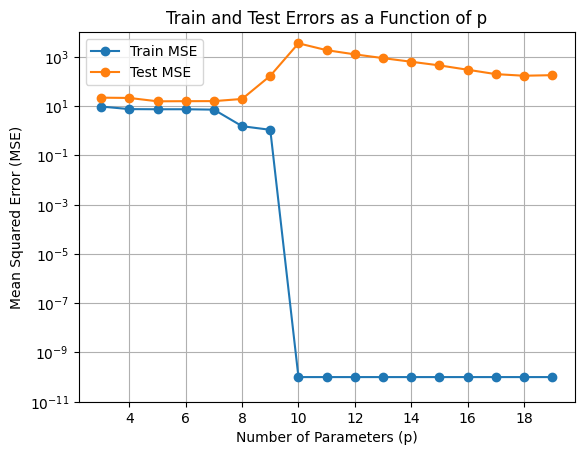

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix

np.random.seed(10)

def true_function(x):
    return 3*np.sin(x) + x

# Generate random x values in the interval [0, 10]
x = np.random.uniform(0, 10, 15)
y = true_function(x) + np.random.normal(0, 3.0, len(x))

# Split the dataset into train and test sets (70% train, 30% test)
split_idx = int(len(x) * 0.7)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# compute_errors

print(x_train.min())
print(x_test.min())
print(len(x_train))

def train_model(spline_basis_train, y_train, p):
    if p + 1 < len(x_train):
        coefficients = np.linalg.solve(spline_basis_train.T @ spline_basis_train, spline_basis_train.T @ y_train)
    else:
        U, s, Vt = np.linalg.svd(spline_basis_train, full_matrices=False)
        s_inv = np.zeros_like(s)
        s_inv[s != 0] = 1 / s[s != 0]
        spline_basis_pinv = Vt.T @ np.diag(s_inv) @ U.T
        coefficients = spline_basis_pinv @ y_train
    return coefficients

def compute_errors(x_train, y_train, x_test, y_test, p):
    common_min = max(x_train.min(), x_test.min())
    common_max = min(x_train.max(), x_test.max())

    knots = np.linspace(common_min + (common_max - common_min) * 0.01,
                        common_max - (common_max - common_min) * 0.01, p - 2)

    spline_basis_train = dmatrix("cr(x, knots=knots) - 1", {"x": x_train, "knots": knots})
    spline_basis_test = dmatrix("cr(x, knots=knots) - 1", {"x": x_test, "knots": knots})

    coefficients = train_model(spline_basis_train, y_train, p)

    y_train_pred = spline_basis_train @ coefficients
    y_test_pred = spline_basis_test @ coefficients

    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)

    return train_mse, test_mse


# Calculate train and test errors for different values of p
p_values = np.arange(3, 2*len(x_train))
errors = np.array([compute_errors(x_train, y_train, x_test, y_test, p) for p in p_values])

# Plot train and test errors as a function of p
plt.plot(p_values, errors[:, 0] + 1e-10, label='Train MSE', marker='o')
plt.plot(p_values, errors[:, 1] + 1e-10, label='Test MSE', marker='o')
plt.xlabel('Number of Parameters (p)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.title('Train and Test Errors as a Function of p')
plt.ylim(1e-11,1e4)
plt.semilogy()
# plt.ylim(0,0.02)
plt.show()



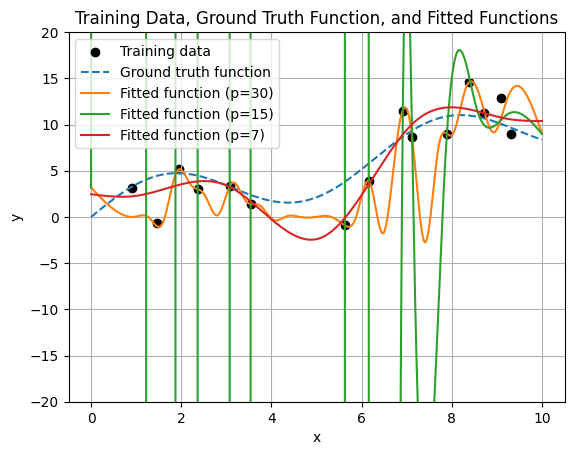

In [176]:
def fit_and_plot():
    # Generate training data
    x_train = np.random.uniform(0, 10, 15)
    y_train = true_function(x_train) + np.random.normal(0, 3.0, len(x_train))

    # Define models
    model_p_values = [
        2*len(x_train),  # Overparametrized model
        len(x_train),    # Interpolation threshold model
        len(x_train)//2  # Underparametrized model
    ]

    # Generate x values for ground truth function and fitted functions
    x_values = np.linspace(0, 10, 1000)
    y_true = true_function(x_values)

    # Plot training data and ground truth function
    plt.scatter(x_train, y_train, c='black', marker='o', label='Training data')
    plt.plot(x_values, y_true, linestyle='--', label='Ground truth function')

    for p in model_p_values:
        common_min = max(x_train.min(), x_values.min())
        common_max = min(x_train.max(), x_values.max())
        knots = np.linspace(common_min + (common_max - common_min) * 0.01,
                            common_max - (common_max - common_min) * 0.01, p - 2)
        
        spline_basis_train = dmatrix("cr(x, knots=knots) - 1", {"x": x_train, "knots": knots})
        spline_basis_values = dmatrix("cr(x, knots=knots) - 1", {"x": x_values, "knots": knots})

        coefficients = train_model(spline_basis_train, y_train, p)
        y_fitted = spline_basis_values @ coefficients

        plt.plot(x_values, y_fitted, label=f'Fitted function (p={p})')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.ylim(-20,20)
    plt.grid()
    plt.title('Training Data, Ground Truth Function, and Fitted Functions')
    plt.show()

fit_and_plot()
